In [ ]:
cwk_dir ="drive/MyDrive/NLU Coursework/" #For running in Jack's Google Drive

# Setup

## Connect Google Drive Folder

In [ ]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')

Mounted at /content/drive/


## Imports

In [ ]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Add, Layer, LSTM, Bidirectional, Embedding, concatenate, BatchNormalization, SimpleRNN, Attention, GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D, MaxPooling1D, TimeDistributed, subtract, multiply
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import SparseCategoricalAccuracy as Acc
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy as KAcc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

import keras
from keras.utils import to_categorical

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import typing
from PIL import Image
import json
from nltk.corpus import stopwords
import gensim.downloader as api
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import string
from random import randint
from itertools import chain
import spacy

In [ ]:
from transformers import XLNetTokenizer, XLNetModel

In [ ]:
#Imports from local libraries
sys.path.append(cwk_dir)
from classes.evaluation import evaluate, draw_confusion_matrix, most_confused_samples
from classes.preprocessing import load_data

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

## Primary Variables

Filepath variables

In [ ]:
solution_dir = os.path.join(cwk_dir, "solution_B")
models_dir = os.path.join(solution_dir, "models_final")
results_dir = os.path.join(solution_dir, "results")

Preprocessing variables

In [ ]:
PADDING: str = "post"

Training variables

In [ ]:
INITIAL_LR: float = 0.001

EPOCHS: int = 20
VALIDATION_SPLIT: float = 0.2
BATCH_SIZE: int = 256
DROPOUT: float = 0.5

LOSS_FUNCTION: str = "categorical_crossentropy"
OUTPUT_ACTIVATION: str = "softmax"
NUM_LABELS: int = 2

OPTIMIZER = RMSprop(INITIAL_LR)

Other

In [ ]:
MAX_PREMISE_LENGTH: int = None
MAX_HYPOTHESIS_LENGTH: int = None

VOCAB_SIZE: int = None
EMBEDDING_SIZE: int = None

## Functions

In [ ]:
def average_sequence_length(sequence: typing.List[str]) -> int:
  """
  Takes a list of sentences & returns the average length of sentences in that sequence
  """
  lengths = [len(sample) for sample in sequence]
  return int(np.sum(lengths)/len(lengths)) + 1

In [ ]:
def show_model_architecture(model: Model, filename: str) -> None:
  """
  Takes a model architecture and will a diagram of the architecture. Saves this diagram also, to the filename specified
  """
  model.summary()
  filename = os.path.join(results_dir, filename)
  plot_model(model, to_file=filename)
  img = Image.open(filename)
  fig, ax = plt.subplots(figsize=(15, 15))
  plt.imshow(img, aspect='equal')

In [ ]:
def tokenize_data(tokenizer: BertTokenizer, premises: typing.List[str], hypotheses: typing.List[str]) ->typing.Tuple[np.array, np.array]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses. Will then pad the sequences correctly, using the maxlen passed in
  """
  premises = [tokenizer.encode(premise, add_special_tokens=True) for premise in premises]
  hypotheses = [tokenizer.encode(hypothesis, add_special_tokens=True) for hypothesis in hypotheses]

  premises = pad_sequences(premises, maxlen=MAX_PREMISE_LENGTH, padding=PADDING, value=0)
  hypotheses = pad_sequences(hypotheses, maxlen=MAX_HYPOTHESIS_LENGTH, padding=PADDING, value=0)

  return (np.array(premises), np.array(hypotheses))

In [ ]:
def save_keras_model(model: Model, filename: str) -> None:
  """
  Saves the model that's been made
  """
  model.save_weights(os.path.join(models_dir, f"{filename}.hdf5"))
  model_architecture = model.to_json()
  with open(os.path.join(models_dir, f"{filename}.json"), "w") as f:
    f.write(json.dumps(model_architecture, indent=4))

In [ ]:
def plot_history(history, export_path, legend: typing.List[str] = ['train', 'test']):
  """
  Will plot the history of a model, labelling it appropriately
  """
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.savefig(os.path.join(results_dir, export_path))

  plt.show()


# Data Preprocessing

## Load Data

In [ ]:
(train_premises, train_hypotheses, train_labels), (dev_premises, dev_hypotheses, dev_labels) = load_data(cwk_dir)

In [ ]:
dev_premises_og = dev_premises
dev_hypotheses_og = dev_hypotheses

In [ ]:
MAX_PREMISE_LENGTH: int = average_sequence_length(sequence=train_premises)
MAX_HYPOTHESIS_LENGTH: int = average_sequence_length(sequence=train_hypotheses)

print(f"MAX_PREMISE_LENGTH: {MAX_PREMISE_LENGTH}")
print(f"MAX_HYPOTHESIS_LENGTH: {MAX_HYPOTHESIS_LENGTH}")

MAX_PREMISE_LENGTH: 110
MAX_HYPOTHESIS_LENGTH: 60


In [ ]:
train_labels = to_categorical(train_labels)
dev_labels = to_categorical(dev_labels)

### Example

In [ ]:
index = randint(0, len(train_premises))
print(f"Premise: {train_premises[index]}")
print(f"Hypothesis: {train_hypotheses[index]}")
print(f"Label: {train_labels[index]}")

Premise: i admit that i used to be hooked on Dallas but back way long time ago when Jock died i gave up watching it it just got too funny
Hypothesis: I was never a fan of Dallas because it was just never funny enough for me. 
Label: [1. 0.]


## Tokenize Data

In [ ]:
BERT_ID = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(BERT_ID, do_lower_case=False)
bert_model = XLNetModel.from_pretrained(BERT_ID)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

In [ ]:
train_premises, train_hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(train_premises), hypotheses=list(train_hypotheses))
dev_premises, dev_hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(dev_premises), hypotheses=list(dev_hypotheses))

In [ ]:
VOCAB_SIZE = tokenizer.vocab_size
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 32000


### Example

In [ ]:
#Premise
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_premises[index])}")
print(f"Tokens: {train_premises[index]}")

Sentence: ['▁', 'i', '▁admit', '▁that', '▁', 'i', '▁used', '▁to', '▁be', '▁hooked', '▁on', '▁Dallas', '▁but', '▁back', '▁way', '▁long', '▁time', '▁ago', '▁when', '▁J', 'ock', '▁died', '▁', 'i', '▁gave', '▁up', '▁watching', '▁it', '▁it', '▁just', '▁got', '▁too', '▁funny', '<sep>', '<cls>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']
Tokens: [   17   150  6024    29   

In [ ]:
#Hypothesis
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_hypotheses[index])}")
print(f"Tokens: {train_hypotheses[index]}")

Sentence: ['▁I', '▁was', '▁never', '▁a', '▁fan', '▁of', '▁Dallas', '▁because', '▁it', '▁was', '▁just', '▁never', '▁funny', '▁enough', '▁for', '▁me', '.', '<sep>', '<cls>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']
Tokens: [  35   30  287   24 3054   20 4337  149   36   30  125  287 5787  456
   28  110    9    4    3    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


## Embedding Matrix

In [ ]:
embedding_matrix = bert_model.get_input_embeddings().weight.detach().numpy()

In [ ]:
if(EMBEDDING_SIZE is None):
  EMBEDDING_SIZE = np.shape(embedding_matrix)[1]
print(f"Embedding size: {EMBEDDING_SIZE}")

Embedding size: 768


# Model Training

In [ ]:
model_name = "combined"

## Model Architecture

In [ ]:
OPTIMIZER = RMSprop(INITIAL_LR)
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.00001, min_delta=0.01)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_22 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                                  
 embedding_9 (Embedding)     multiple                     2457600   ['input_21[0][0]',            
                                                          0          'input_22[0][0]']            
                                                                                                  
 bidirectional_9 (Bidirecti  multiple                     5246976   ['embedding_9[0][0]',   

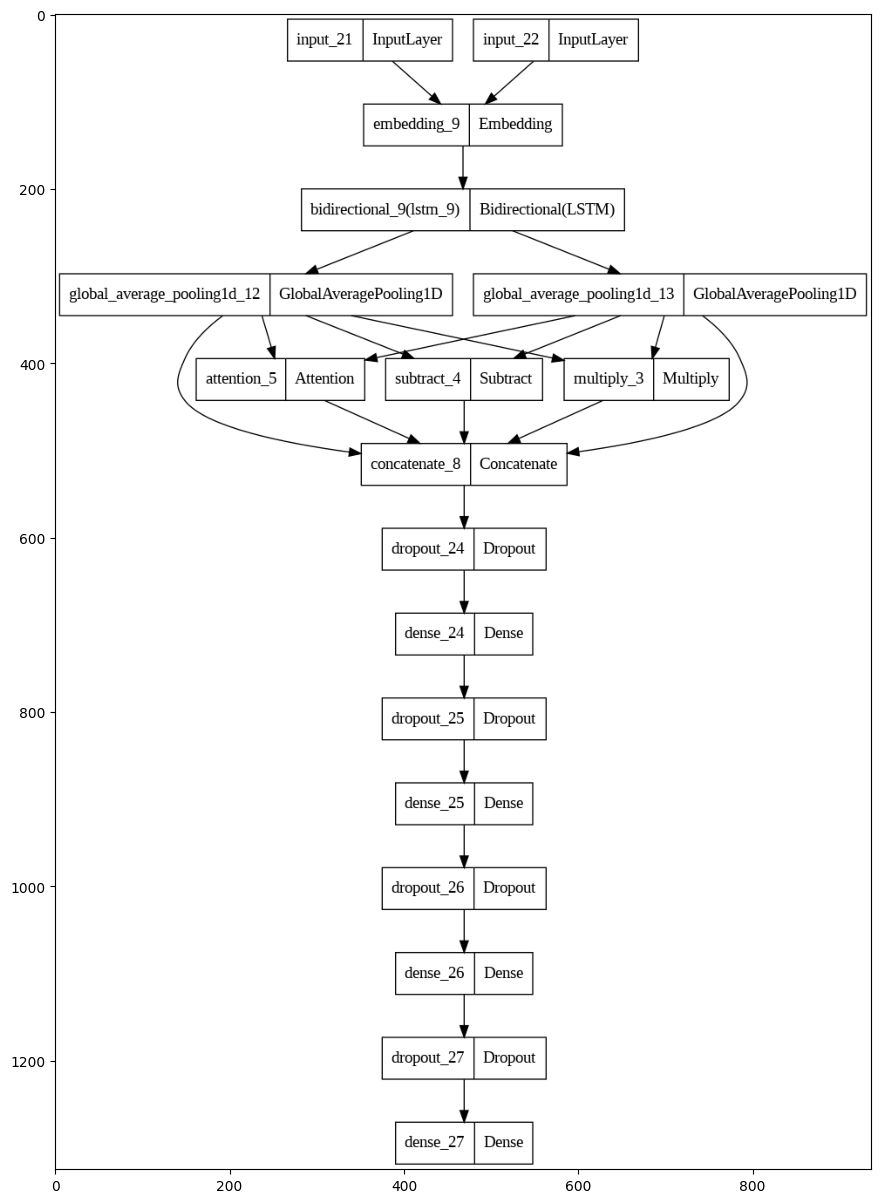

In [ ]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=True, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

premises_pooling = GlobalAveragePooling1D()(premises)
hypotheses_pooling = GlobalAveragePooling1D()(hypotheses)

sub = subtract([premises_pooling, hypotheses_pooling])
mul = multiply([premises_pooling, hypotheses_pooling])
attention = Attention()([premises_pooling, hypotheses_pooling])
merged = concatenate([premises_pooling, hypotheses_pooling, attention, sub, mul], axis=-1)

x = Dropout(DROPOUT)(merged)
x = Dense(2048, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(DROPOUT)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Model Training

In [ ]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[callback])

Epoch 1/20
85/85 [==============================] - 24s 212ms/step - loss: 0.7419 - accuracy: 0.5163 - val_loss: 0.6880 - val_accuracy: 0.5485 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 16s 189ms/step - loss: 0.6765 - accuracy: 0.5686 - val_loss: 0.6540 - val_accuracy: 0.6252 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 16s 190ms/step - loss: 0.6378 - accuracy: 0.6399 - val_loss: 0.6143 - val_accuracy: 0.6662 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 16s 190ms/step - loss: 0.6097 - accuracy: 0.6678 - val_loss: 0.5971 - val_accuracy: 0.6669 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 16s 190ms/step - loss: 0.5981 - accuracy: 0.6767 - val_loss: 0.6005 - val_accuracy: 0.6678 - lr: 0.0010
Epoch 6/20
85/85 [==============================] - 16s 189ms/step - loss: 0.5861 - accuracy: 0.6913 - val_loss: 0.5694 - val_accuracy: 0.6851 - lr: 0.0010
Epoch 7/20
85/85 [==============================] - 16s 190ms/st

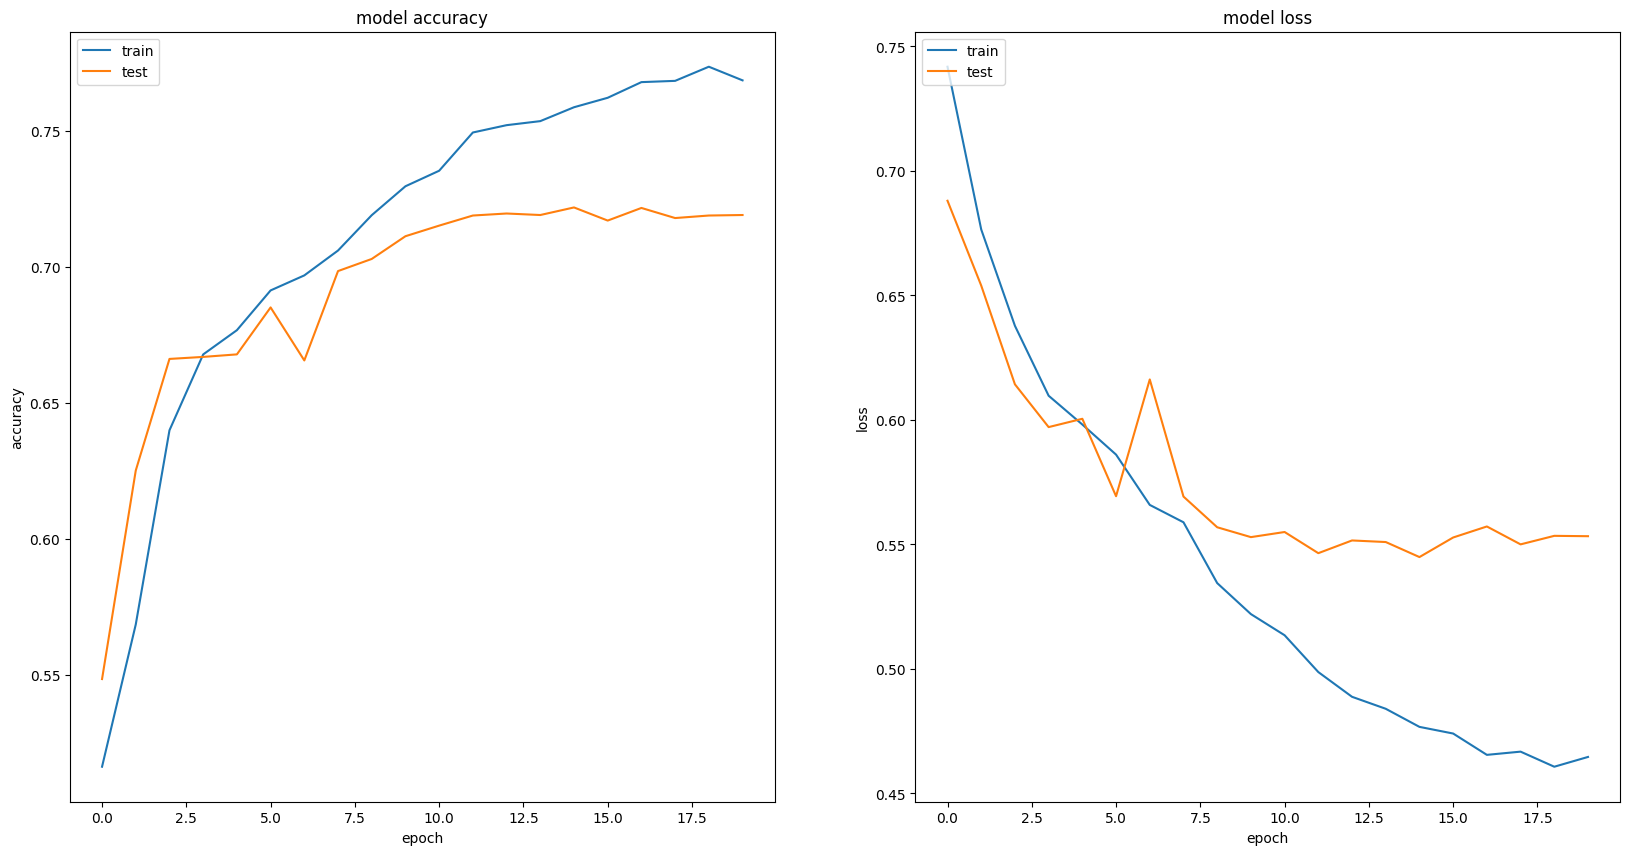

In [ ]:
plot_history(history=history, export_path=f"{model_name}_architecture.pdf")

In [ ]:
#Save the model
save_keras_model(model=model, filename=model_name)

## Model Evaluation

In [ ]:
predicted_logits = model.predict(x=[dev_premises, dev_hypotheses])
true_labels=np.argmax(dev_labels, axis=1)

#Evaluation Metrics
test_metrics = evaluate(true_labels=true_labels, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 3s 16ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.727772,0.728207,0.72774,0.727755,0.754169,0.726885,0.727772,0.74096,0.727065,0.727516,0.454624,0.535476


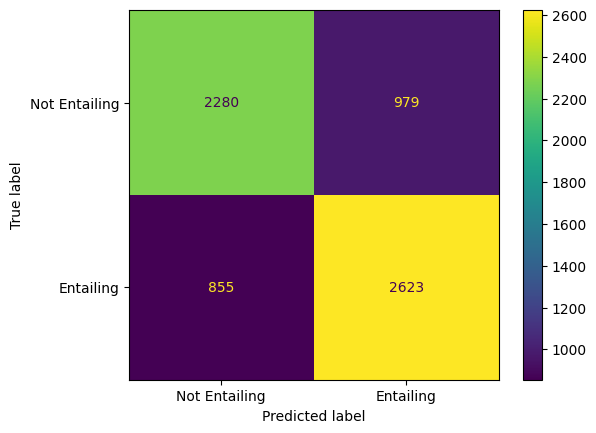

In [ ]:
conf_mat = draw_confusion_matrix(true_labels=true_labels, predicted_logits=np.array(predicted_logits))

In [ ]:
df = most_confused_samples(true_logits=dev_labels, predicted_logits=np.array(predicted_logits), premises=dev_premises_og, hypotheses=dev_hypotheses_og, num=10)
df.to_csv(os.path.join(results_dir, f"{model_name}_most_confused.csv"), index=False)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,He was the first scholar to describe in detail.,He was the first scholar to describe in detail...,11.881137,1,0
1,"La Barredora (""The Sweeper Truck"") is a crimin...","La Barredora (""The Sweeper Truck"") is a crimin...",6.591391,1,0
2,"Today, Italy; tomorrow, who knows?",The trip to Italy will deplete my bank account...,5.636950,1,0
3,Traditional examples of background music inclu...,Traditional examples of background music inclu...,5.580024,1,0
4,Association for Federal Information Resources ...,The Government Executive magazine provides add...,5.529576,0,1
5,"Bryant for introducing the bill, Payne said.","Since the bill had already been introduced, Pa...",5.411198,1,0
6,no i'm sure you know that's one thing you don'...,I don't know whether you know if you should do...,5.375714,1,0
7,It's that interaction with fiscal policy that ...,It's that interaction with the criminal law is...,5.345931,1,0
8,"However, we are so sophisticated psychometrica...",No research can be dissected by methodology al...,5.317111,0,1
9,you want to have that coverage so anyway uh bu...,No press is bad press,5.285258,0,1
